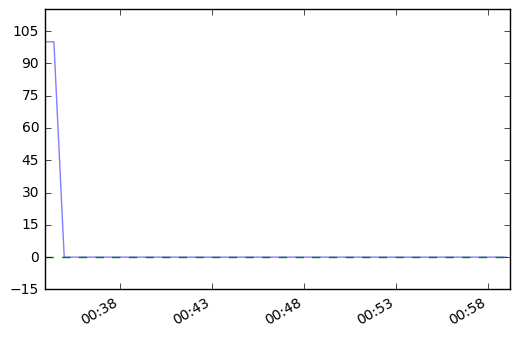

In [49]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.dates as mdate
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.transforms as mtransforms
import matplotlib.text as mtext
from flair_api import make_client, Resource
from flair_api.client import ApiError
from datetime import datetime

CLIENT_ID = ''
CLIENT_SECRET = ''
API_ROOT = 'https://api.flair.co'

class VentState(Resource):
    @property
    def name(self):
        return 'Desired'
    
    @property
    def x(self):
        return datetime.strptime(
            self.attributes['created-at'], 
            '%Y-%m-%dT%H:%M:%S.%f+00:00'
        )
        
    @property
    def y(self):
        return self.attributes['percent-open']
    
class VentSensorReading(Resource):
    @property
    def name(self):
        return 'Actual'
    
    @property
    def x(self):
        return datetime.strptime(
            self.attributes['created-at'], 
            '%Y-%m-%dT%H:%M:%S.%f+00:00'
        )
    
    @property
    def y(self):
        return self.attributes['percent-open']

client = make_client(
    CLIENT_ID, CLIENT_SECRET, API_ROOT,
    mapper={
        'vent-sensor-readings': VentSensorReading,
        'vent-states': VentState
    }
) 

hours = mdate.HourLocator()
minutes = mdate.MinuteLocator(interval=5)
hoursfmt = mdate.DateFormatter("%H:%M")
major_ticks = np.arange(-15, 115, 15)    

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(minutes)
ax.xaxis.set_major_formatter(hoursfmt)
ax.set_yticks(major_ticks)
ax.set_ylim([-15,115])

try:
    structure = client.get("structures", id="55")

    vents = structure.get_rel("vents")

    for vent in vents:
        sensor_readings = vent.get_rel('sensor-readings')
        states = vent.get_rel('vent-states')
        current_state = vent.get_rel('current-state')
        reading_x = [sr.x for sr in sensor_readings]
        earliest_date = min(reading_x)
        
        ax.plot_date(
            mdate.date2num(reading_x),
            [sr.y for sr in sensor_readings],
            linestyle='-',
            marker=None,
            alpha=0.5
        )
        state_times = [vs.x for vs in states
                       if vs.x >= earliest_date]
        if state_times:
            add_current = [datetime.utcnow()]
            data = [current_state.attributes['percent-open']]
        else:
            add_current = [earliest_date, datetime.utcnow()]
            data = [current_state.attributes['percent-open'], current_state.attributes['percent-open']]
            
        ax.plot_date(
            mdate.date2num(state_times + add_current),
            [vs.y for vs in states
             if vs.x >= earliest_date] + data,
            linestyle='--',
            marker=None
        )


except ApiError as e:
    print(e.status_code)
    print(e.json)
    
fig.autofmt_xdate()    
plt.show()